In [1]:
def get_significance(p):
    if p<0.01:
    
        significance="***"
    elif p<0.05:
        significance="**"
    elif p<0.1:
        significance="*"
    else:
        significance="_"
    return significance

# Dependencies

In [2]:
#visualization
import matplotlib.pyplot as plt

#math tools
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import resample
from scipy.signal import decimate

#stat tools
from scipy.stats import pearsonr#2 continuous variable
from scipy.stats import spearmanr#1 binary and 1 continuous variable
from scipy.stats import ttest_ind
from scipy.stats import bartlett
from scipy.stats import shapiro
#utils
from time import time
from os.path import join
from os import listdir
#custom
from utils import *
from load_data import *


# Data
## Loading

In [3]:
## Loading
#Cf `load_data.py`
task_i=task2index["spiral"]
compute_movement=False
downsampling_factor=1
window_size=None
paper_air_split=False
try:
    assert window_size is None or not paper_air_split
except AssertionError:
    print("you have to choose between subsequences of fixed length and strokes !")
else:
    print("\nloading and massaging data, this might take a few seconds...")
    data_gen=load_data()
    data,targets,ages=[],[],[]
    for subject,label,age in data_gen:
        data.append(subject)
        targets.append(label)
        ages.append(age)
    print("(75-3 subjects, 8 tasks, X timesteps, 7 measures)")
    print(len(data),len(data[0]),len(data[0][0]),len(data[0][0][0]))
    #data, targets= massage_data(data, targets,task_i, compute_movement, downsampling_factor, window_size,paper_air_split)


loading and massaging data, this might take a few seconds...
(75-3 subjects, 8 tasks, X timesteps, 7 measures)
72 8 1772 7


In [4]:
patients_ages,control_ages=[],[]
patients_lengths,control_lengths=[],[]
patients_time,control_time=[],[]
patients_index,control_index=[],[]
for i,age in enumerate(ages):
    if targets[i]==1:
        patients_ages.append(age)
        patients_lengths.append([len(task) for task in data[i]])
        patients_time.append([task[-1][2]-task[0][2] for task in data[i]])
        patients_index.append(i)
    else:
        control_ages.append(age)
        control_lengths.append([len(task) for task in data[i]])
        control_time.append([task[-1][2]-task[0][2] for task in data[i]])
        control_index.append(i)
patients_lengths,control_lengths=np.asarray(patients_lengths),np.asarray(control_lengths)
patients_time,control_time=np.asarray(patients_time),np.asarray(control_time)

The timestamp measure of the first subject's spiral doesn't contain any pauses so we use it to convert the time stamp to ms.

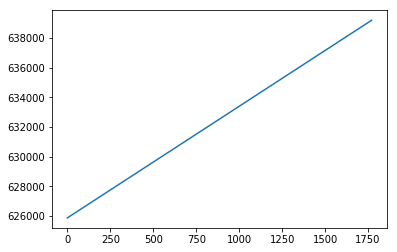

In [5]:
plt.plot(np.asarray(data[0][0])[:,2])

In [6]:
print("len(data[0][0])*1000/200 :",len(data[0][0])*1000/200)
print("we divide by 200 because it's the sampling rate and multiply by 1000 to get ms.")
print("t_n - t_0 :",data[0][0][-1][2]-data[0][0][0][2])
print("so we can can conclude that there's a factor of {} between the time stamp and ms".format(
(data[0][0][-1][2]-data[0][0][0][2])/(len(data[0][0])*1000/200)))
control_time/=1.5
patients_time/=1.5
times=np.concatenate((patients_time,control_time),axis=0)
times.shape

median=np.median(np.mean(times,axis=1))

medians=np.median(times,axis=0)

len(data[0][0])*1000/200 : 8860.0
we divide by 200 because it's the sampling rate and multiply by 1000 to get ms.
t_n - t_0 : 13310.0
so we can can conclude that there's a factor of 1.502257336343115 between the time stamp and ms


So we have divide the task time by `1.5` in order to get ms.
See below how the plots of time and length are then merged into one, except on some subjects that did pause (see `DetectPause`)

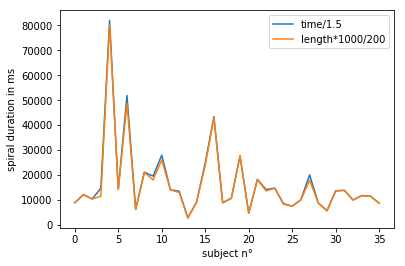

In [287]:
plt.xlabel("subject n°")
plt.ylabel("spiral duration in ms")
plt.plot(patients_time[:,0],label="time/1.5")
plt.plot(patients_lengths[:,0]*1000/200,label="length*1000/200")
plt.legend()

In [311]:
def rule_based(threshold,patients_lengths,control_lengths):
    tp=len([i for i in patients_lengths if i >threshold])
    fp=len(patients_lengths)-tp

    tn=len([i for i in control_lengths if i <=threshold])
    fn=len(control_lengths)-tn
    accuracy,sensitivity,specificity,ppv,npv=return_metrics(tp,tn,fp,fn)
    results=""
    for metric in [accuracy,sensitivity,specificity,ppv,npv]:
        results+=" | {:.2f}".format(metric)
    print(results)

# Classification


In [314]:
for i,task in enumerate(index2task):
    print(task,end="")
    rule_based(medians[i],patients_time[:,0],control_time[:,0])

spiral | 0.53 | 0.53 | 0.53 | 0.53 | 0.53
l | 0.56 | 0.53 | 0.64 | 0.86 | 0.25
le | 0.53 | 0.52 | 0.54 | 0.69 | 0.36
les | 0.56 | 0.55 | 0.56 | 0.58 | 0.53
lektorka | 0.54 | 0.54 | 0.54 | 0.56 | 0.53
porovnat | 0.53 | 0.52 | 0.53 | 0.61 | 0.44
nepopadnout | 0.50 | 0.50 | 0.50 | 0.89 | 0.11
tram | 0.51 | 0.53 | 0.51 | 0.28 | 0.75


In [5]:
md="""task|Accuracy|Se | Sp | PPV | NPV
--|--|--|--|--|--
spiral | 0.53 | 0.53 | 0.53 | 0.53 | 0.53
l | 0.56 | 0.53 | 0.64 | 0.86 | 0.25
le | 0.53 | 0.52 | 0.54 | 0.69 | 0.36
les | 0.56 | 0.55 | 0.56 | 0.58 | 0.53
lektorka | 0.54 | 0.54 | 0.54 | 0.56 | 0.53
porovnat | 0.53 | 0.52 | 0.53 | 0.61 | 0.44
nepopadnout | 0.50 | 0.50 | 0.50 | 0.89 | 0.11
tram | 0.51 | 0.53 | 0.51 | 0.28 | 0.75
all | 0.58 | 0.58 | 0.58 | 0.58 | 0.58"""

In [23]:
def markdown_to_latex(md):
    table=md.split("\n")
    n_lines=len(table)
    n_cols=len(table[0].split("|"))

   # latex="\\begin\{table\}[width=.9\\linewidth,cols=\{\},pos=h]\n".format(n_cols)
    #latex+="\\caption\{ADD CAPTION HERE\}\\label\{TABLE_LABEL\}\n"
    #latex+="\\begin\{tabular*\}\{\\tblwidth\}{@\{\} LLLL@\{\} } \n "
    latex="\\toprule\n"
    for col_name in table[0].split("|")[:-1]:
        latex+= col_name+" & "
    latex+=table[0][-1]+ " \\\\ \n \\midrule \n"
    for lines in table[2:]:
        for item in lines.split("|")[:-1]:
            latex+= item+" & "
        latex+=lines.split("|")[-1]+" \\\\ \n"
    latex+="\\bottomrule \n "#\\end\{tabular*\} \n \\end\{table\}"
    return latex

In [26]:
print(markdown_to_latex("""task | t-statistic | t p-value | significance| bartlett statistic | bartlett p-value | patients_shapiro statistic | patients_shapiro  p-value| control_shapiro statistic| control_shapiro p-value
--|--|--|--|--|--|--|--|--|--
spiral |1.5826 | 0.1180 |_ | 23.1519| 1.497e-06| 0.6660| 8.599e-08| 0.8897| 1.808e-03
l |0.1849 | 0.8538 |_ | 0.0450| 8.319e-01| 0.9268| 2.005e-02| 0.8648| 4.253e-04
le |1.3512 | 0.1810 |_ | 2.8645| 9.056e-02| 0.8640| 4.068e-04| 0.8371| 9.749e-05
les |1.4268 | 0.1581 |_ | 7.9001| 4.943e-03| 0.8746| 7.396e-04| 0.9084| 5.847e-03
lektorka |1.4210 | 0.1598 |_ | 16.0263| 6.247e-05| 0.8274| 6.000e-05| 0.9318| 2.846e-02
porovnat |0.9418 | 0.3495 |_ | 4.3517| 3.697e-02| 0.9048| 4.632e-03| 0.9288| 2.308e-02
nepopadnout |1.4159 | 0.1612 |_ | 12.5337| 3.997e-04| 0.8293| 6.579e-05| 0.9181| 1.106e-02
tram |1.0952 | 0.2772 |_ | 5.0368| 2.481e-02| 0.8360| 9.203e-05| 0.9364| 3.923e-02
all |1.5799 | 0.1186 |_| 7.6017| 5.831e-03| 0.9006| 3.547e-03| 0.9370| 4.099e-02"""))

\toprule
task  &  t-statistic  &  t p-value  &  significance &  bartlett statistic  &  bartlett p-value  &  patients_shapiro statistic  &  patients_shapiro  p-value &  control_shapiro statistic & e \\ 
 \midrule 
spiral  & 1.5826  &  0.1180  & _  &  23.1519 &  1.497e-06 &  0.6660 &  8.599e-08 &  0.8897 &  1.808e-03 \\ 
l  & 0.1849  &  0.8538  & _  &  0.0450 &  8.319e-01 &  0.9268 &  2.005e-02 &  0.8648 &  4.253e-04 \\ 
le  & 1.3512  &  0.1810  & _  &  2.8645 &  9.056e-02 &  0.8640 &  4.068e-04 &  0.8371 &  9.749e-05 \\ 
les  & 1.4268  &  0.1581  & _  &  7.9001 &  4.943e-03 &  0.8746 &  7.396e-04 &  0.9084 &  5.847e-03 \\ 
lektorka  & 1.4210  &  0.1598  & _  &  16.0263 &  6.247e-05 &  0.8274 &  6.000e-05 &  0.9318 &  2.846e-02 \\ 
porovnat  & 0.9418  &  0.3495  & _  &  4.3517 &  3.697e-02 &  0.9048 &  4.632e-03 &  0.9288 &  2.308e-02 \\ 
nepopadnout  & 1.4159  &  0.1612  & _  &  12.5337 &  3.997e-04 &  0.8293 &  6.579e-05 &  0.9181 &  1.106e-02 \\ 
tram  & 1.0952  &  0.2772  & _  &  5.0

In [3]:
table=md.split("\n")
n_lines=len(table)
n_cols=len(table[0].split("|"))


## when setting threshold at median(subjects_lengths)



task|Accuracy|Se | Sp | PPV | NPV
--|--|--|--|--|--
spiral | 0.53 | 0.53 | 0.53 | 0.53 | 0.53
l | 0.56 | 0.53 | 0.64 | 0.86 | 0.25
le | 0.53 | 0.52 | 0.54 | 0.69 | 0.36
les | 0.56 | 0.55 | 0.56 | 0.58 | 0.53
lektorka | 0.54 | 0.54 | 0.54 | 0.56 | 0.53
porovnat | 0.53 | 0.52 | 0.53 | 0.61 | 0.44
nepopadnout | 0.50 | 0.50 | 0.50 | 0.89 | 0.11
tram | 0.51 | 0.53 | 0.51 | 0.28 | 0.75
all | 0.58 | 0.58 | 0.58 | 0.58 | 0.58

## with LDA : random 50-50 split with 15 runs

task|Accuracy|Se | Sp | PPV | NPV
--|--|--|--|--|--
spiral | 50.56 ± (6.97) | 38.52 ± (14.27) | 62.59 ± (22.17) | 52.97 ± (9.01) | 48.65 ± (9.00) | 
l | 48.52 ± (7.23) | 50.37 ± (20.23) | 46.67 ± (20.96) | 48.64 ± (7.13) | 48.14 ± (9.38) | 
le | 58.33 ± (6.25) | 48.52 ± (14.27) | 68.15 ± (18.08) | 62.83 ± (9.78) | 56.94 ± (5.96) | 
les | 55.93 ± (3.91) | 44.81 ± (10.24) | 67.04 ± (13.06) | 58.59 ± (6.39) | 54.78 ± (2.83) | 
lektorka | 48.70 ± (6.24) | 40.37 ± (11.01) | 57.04 ± (14.83) | 48.89 ± (6.96) | 48.19 ± (7.21) | 
porovnat | 49.63 ± (6.16) | 41.11 ± (9.69) | 58.15 ± (12.32) | 49.79 ± (6.98) | 49.29 ± (6.55) | 
nepopadnout | 50.19 ± (6.99) | 44.81 ± (11.91) | 55.56 ± (14.49) | 50.46 ± (7.09) | 49.60 ± (8.36) | 
tram | 51.30 ± (5.73) | 42.22 ± (13.88) | 60.37 ± (12.32) | 51.59 ± (7.60) | 51.39 ± (5.11) | 
all | 56.48 ± (4.61) | 52.22 ± (12.80) | 60.74 ± (10.03) | 57.15 ± (5.52) | 56.58 ± (5.09) | 

### using age as feature 
Accuracy|Se | Sp | PPV | NPV
--|--|--|--|--
63.70 ± (7.49) | 63.33 ± (13.58) | 64.07 ± (10.90) | 63.99 ± (7.82) | 64.48 ± (8.56) | 

# Correlation
## between task duration and subject's age



In [320]:
corr, p = pearsonr(np.mean(times,axis=1),np.concatenate((patients_ages,control_ages),axis=0))
print(" |{:.4f} | {:.4f} ".format(corr, p ))

for i,task in enumerate(index2task):
    print(task,end="")
    corr, p = pearsonr(times[:,i],np.concatenate((patients_ages,control_ages),axis=0))
    print(" |{:.4f} | {:.4f} ".format(corr, p ))

 |0.3631 | 0.0017 


task | Spearman correlation coefficient | p-value
--|--|--
spiral |0.2163 | 0.0681 
l |0.2557 | 0.0301 
le |0.3088 | 0.0083 
les |0.4225 | 0.0002 
lektorka |0.3086 | 0.0084 
porovnat |0.2787 | 0.0178 
nepopadnout |0.2575 | 0.0290 
tram |0.2814 | 0.0166 
all |0.3631 | 0.0017 

## between task duration and targets
### t-test

task | t-statistic | t p-value | significance| bartlett statistic | bartlett p-value | patients_shapiro statistic | patients_shapiro  p-value| control_shapiro statistic| control_shapiro p-value
--|--|--|--|--|--|--|--|--|--
spiral |1.5826 | 0.1180 |_ | 23.1519| 1.497e-06| 0.6660| 8.599e-08| 0.8897| 1.808e-03
l |0.1849 | 0.8538 |_ | 0.0450| 8.319e-01| 0.9268| 2.005e-02| 0.8648| 4.253e-04
le |1.3512 | 0.1810 |_ | 2.8645| 9.056e-02| 0.8640| 4.068e-04| 0.8371| 9.749e-05
les |1.4268 | 0.1581 |_ | 7.9001| 4.943e-03| 0.8746| 7.396e-04| 0.9084| 5.847e-03
lektorka |1.4210 | 0.1598 |_ | 16.0263| 6.247e-05| 0.8274| 6.000e-05| 0.9318| 2.846e-02
porovnat |0.9418 | 0.3495 |_ | 4.3517| 3.697e-02| 0.9048| 4.632e-03| 0.9288| 2.308e-02
nepopadnout |1.4159 | 0.1612 |_ | 12.5337| 3.997e-04| 0.8293| 6.579e-05| 0.9181| 1.106e-02
tram |1.0952 | 0.2772 |_ | 5.0368| 2.481e-02| 0.8360| 9.203e-05| 0.9364| 3.923e-02
all |1.5799 | 0.1186 |_| 7.6017| 5.831e-03| 0.9006| 3.547e-03| 0.9370| 4.099e-02


In [393]:
np.mean(patients_ages)-np.mean(control_ages)

6.888888888888886

In [390]:
for i,task in enumerate(index2task):
    print(task,end="")
    patients_shapiro = shapiro(patients_time[:,i])

    control_shapiro=shapiro(control_time[:,i])

    bartlett_=bartlett(patients_time[:,i],control_time[:,i])
    corr, p = ttest_ind(patients_time[:,i],control_time[:,i])
    significance=get_significance(p)
    print(" |{:.4f} | {:.4f} |{} | {:.4f}| {:.3e}| {:.4f}| {:.3e}| {:.4f}| {:.3e}".format(corr, p ,significance,
        bartlett_[0],bartlett_[1],patients_shapiro[0],patients_shapiro[1],control_shapiro[0],control_shapiro[1]))

spiral |1.5826 | 0.1180 |_ | 23.1519| 1.497e-06| 0.6660| 8.599e-08| 0.8897| 1.808e-03
l |0.1849 | 0.8538 |_ | 0.0450| 8.319e-01| 0.9268| 2.005e-02| 0.8648| 4.253e-04
le |1.3512 | 0.1810 |_ | 2.8645| 9.056e-02| 0.8640| 4.068e-04| 0.8371| 9.749e-05
les |1.4268 | 0.1581 |_ | 7.9001| 4.943e-03| 0.8746| 7.396e-04| 0.9084| 5.847e-03
lektorka |1.4210 | 0.1598 |_ | 16.0263| 6.247e-05| 0.8274| 6.000e-05| 0.9318| 2.846e-02
porovnat |0.9418 | 0.3495 |_ | 4.3517| 3.697e-02| 0.9048| 4.632e-03| 0.9288| 2.308e-02
nepopadnout |1.4159 | 0.1612 |_ | 12.5337| 3.997e-04| 0.8293| 6.579e-05| 0.9181| 1.106e-02
tram |1.0952 | 0.2772 |_ | 5.0368| 2.481e-02| 0.8360| 9.203e-05| 0.9364| 3.923e-02


In [387]:

patients_shapiro = shapiro(np.mean(patients_time,axis=1))

control_shapiro=shapiro(np.mean(control_time,axis=1))

bartlett_=bartlett(np.mean(patients_time,axis=1),np.mean(control_time,axis=1))
corr, p = ttest_ind(np.mean(patients_time,axis=1),np.mean(control_time,axis=1))
significance=get_significance(p)
print(" |{:.4f} | {:.4f} |{} | {:.4f}| {:.3e}| {:.4f}| {:.3e}| {:.4f}| {:.3e}".format(corr, p ,significance,
    bartlett_[0],bartlett_[1],patients_shapiro[0],patients_shapiro[1],control_shapiro[0],control_shapiro[1]))

 |1.5799 | 0.1186 |_ | 7.6017| 5.831e-03| 0.9006| 3.547e-03| 0.9370| 4.099e-02




### Spearman

In [360]:
for i,task in enumerate(index2task):
    print(task,end="")
    corr, p = spearmanr(times[:,i],[1 for _ in range(36)]+[0 for _ in range( 36)])
    print(" |{:.4f} | {:.4f} ".format(corr, p ))

spiral |0.1343 | 0.2606 
l |0.0762 | 0.5247 
le |0.1497 | 0.2094 
les |0.0936 | 0.4344 
lektorka |0.0642 | 0.5924 
porovnat |0.0695 | 0.5618 
nepopadnout |0.1056 | 0.3774 
tram |0.0855 | 0.4749 




task | Spearman correlation coefficient | p-value
--|--|--
spiral |0.1343 | 0.2606 
l |0.0762 | 0.5247 
le |0.1497 | 0.2094 
les |0.0936 | 0.4344 
lektorka |0.0642 | 0.5924 
porovnat |0.0695 | 0.5618 
nepopadnout |0.1056 | 0.3774 
tram |0.0855 | 0.4749 
all |0.1283 | 0.2828 

## between subject ages and targets 
### t-test
 t-statistic | t p-value | significance| bartlett statistic | bartlett p-value | patients_shapiro statistic | patients_shapiro  p-value| control_shapiro statistic| control_shapiro p-value
--|--|--|--|--|--|--|--|--
 2.5606 | 0.0126 |** | 0.0888| 7.656e-01| 0.9686| 3.883e-01| 0.9685| 3.862e-01

In [401]:
patients_shapiro = shapiro(patients_ages)

control_shapiro=shapiro(control_ages)

bartlett_=bartlett(patients_ages,control_ages)
corr, p = ttest_ind(patients_ages,control_ages)
significance=get_significance(p)
print(" |{:.4f} | {:.4f} |{} | {:.4f}| {:.3e}| {:.4f}| {:.3e}| {:.4f}| {:.3e}".format(corr, p ,significance,
    bartlett_[0],bartlett_[1],patients_shapiro[0],patients_shapiro[1],control_shapiro[0],control_shapiro[1]))

 |2.5606 | 0.0126 |** | 0.0888| 7.656e-01| 0.9686| 3.883e-01| 0.9685| 3.862e-01


### Spearman

In [358]:
corr, p = spearmanr(ages,targets)
print(" |{:.4f} | {:.3e} ".format(corr, p ))

 |0.3097 | 8.112e-03 


 Spearman correlation coefficient | p-value
--|--
 0.3097 | 8.112e-03 

# Classification with LinearDiscriminantAnalysis
## Single task assessment

In [363]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from utils import confusion_matrix,return_metrics

targets=np.asarray([1 for _ in range(36)]+[0 for _ in range( 36)])
for i,task in enumerate(index2task):
    model = LinearDiscriminantAnalysis()
    features=np.asarray(times[:,i])
    skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    #cv_generator=skf.split(features,targets)
    metrics=[]
    for random_state in range(15):
    #for train_index, test_index in cv_generator:
        train_data,test_data,train_targets,test_targets=train_test_split(
            features,targets,test_size=0.5,stratify=targets,random_state=random_state)
        #train_data,test_data=features[train_index],features[test_index]
        #train_targets,test_targets=targets[train_index],targets[test_index]
        model.fit(train_data.reshape(-1,1),train_targets)
        predictions=model.predict(test_data.reshape(-1,1))
        tn, fp, fn, tp, _ = confusion_matrix(y_true=test_targets,y_pred=predictions)
        accuracy,sensitivity,specificity,ppv,npv=return_metrics(tp,tn,fp,fn)
        metrics.append([accuracy,sensitivity,specificity,ppv,npv])
    print(task,end=" | ")
    for m,s in list(zip(np.mean(metrics,axis=0)*100,np.std(metrics,axis=0)*100)):
        print("{:.2f} ± ({:.2f})".format(m,s),end=" | ")
    print()

spiral | 50.56 ± (6.97) | 38.52 ± (14.27) | 62.59 ± (22.17) | 52.97 ± (9.01) | 48.65 ± (9.00) | 
l | 48.52 ± (7.23) | 50.37 ± (20.23) | 46.67 ± (20.96) | 48.64 ± (7.13) | 48.14 ± (9.38) | 
le | 58.33 ± (6.25) | 48.52 ± (14.27) | 68.15 ± (18.08) | 62.83 ± (9.78) | 56.94 ± (5.96) | 
les | 55.93 ± (3.91) | 44.81 ± (10.24) | 67.04 ± (13.06) | 58.59 ± (6.39) | 54.78 ± (2.83) | 
lektorka | 48.70 ± (6.24) | 40.37 ± (11.01) | 57.04 ± (14.83) | 48.89 ± (6.96) | 48.19 ± (7.21) | 
porovnat | 49.63 ± (6.16) | 41.11 ± (9.69) | 58.15 ± (12.32) | 49.79 ± (6.98) | 49.29 ± (6.55) | 
nepopadnout | 50.19 ± (6.99) | 44.81 ± (11.91) | 55.56 ± (14.49) | 50.46 ± (7.09) | 49.60 ± (8.36) | 
tram | 51.30 ± (5.73) | 42.22 ± (13.88) | 60.37 ± (12.32) | 51.59 ± (7.60) | 51.39 ± (5.11) | 


## Average over some features
choose with `features = ...`

In [404]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from utils import confusion_matrix,return_metrics

targets=np.asarray([1 for _ in range(36)]+[0 for _ in range( 36)])
model = LinearDiscriminantAnalysis()
features=np.concatenate((patients_ages,control_ages),axis=0).reshape(-1,1)#np.mean(times,axis=1).reshape(-1,1)
skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
cv_generator=skf.split(features,targets)
metrics=[]
for random_state in range(15):
#for train_index, test_index in cv_generator:
    train_data,test_data,train_targets,test_targets=train_test_split(
        features,targets,test_size=0.5,stratify=targets,random_state=random_state)
    #train_data,test_data=features[train_index],features[test_index]
    #train_targets,test_targets=targets[train_index],targets[test_index]
    model.fit(train_data,train_targets)
    predictions=model.predict(test_data)
    tn, fp, fn, tp, _ = confusion_matrix(y_true=test_targets,y_pred=predictions)
    accuracy,sensitivity,specificity,ppv,npv=return_metrics(tp,tn,fp,fn)
    metrics.append([accuracy,sensitivity,specificity,ppv,npv])
for m,s in list(zip(np.mean(metrics,axis=0)*100,np.std(metrics,axis=0)*100)):
    print("{:.2f} ± ({:.2f})".format(m,s),end=" | ")
print()

63.70 ± (7.49) | 63.33 ± (13.58) | 64.07 ± (10.90) | 63.99 ± (7.82) | 64.48 ± (8.56) | 


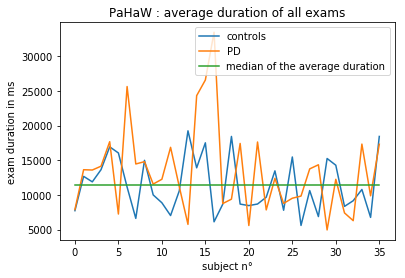

In [302]:
plt.title("PaHaW : average duration of all exams")
plt.plot(np.mean(control_time,axis=1),label="controls")
plt.plot(np.mean(patients_time,axis=1),label="PD")
plt.plot([median for _ in range(36)],label="median of the average duration")
plt.xlabel("subject n°")
plt.ylabel("exam duration in ms")
plt.legend()

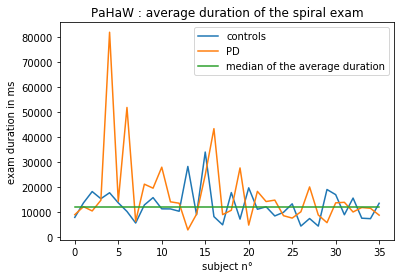

In [310]:
plt.title("PaHaW : average duration of the spiral exam")
plt.plot(control_time[:,0],label="controls")
plt.plot(patients_time[:,0],label="PD")
plt.plot([medians[0] for _ in range(36)],label="median of the average duration")
plt.xlabel("subject n°")
plt.ylabel("exam duration in ms")
plt.legend()

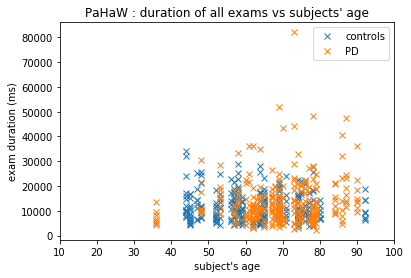

In [296]:
plt.title("PaHaW : duration of all exams vs subjects' age")
plt.xlabel("subject's age")
plt.xlim(10,100)
plt.ylabel("exam duration (ms)")
plt.plot(control_ages*8,flat_list(control_time),'x',label="controls")
plt.plot(patients_ages*8,flat_list(patients_time),'x',label="PD")
plt.legend()

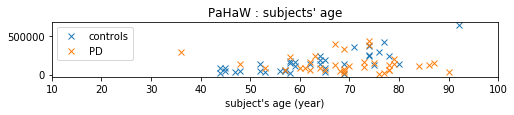

In [16]:
plt.figure(figsize=(8,1))
plt.title("PaHaW : subjects' age")
plt.plot(control_ages,[np.random.rand()*i**3 for i in control_ages],'x',label="controls")
plt.plot(patients_ages,[np.random.rand()*i**3 for i in control_ages],'x',label="PD")
plt.xlim(10,100)
#plt.ylim(-1,2)
plt.xlabel("subject's age (year)")
plt.legend()

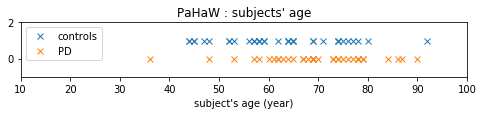

In [415]:
plt.figure(figsize=(8,1))
plt.title("PaHaW : subjects' age")
plt.plot(control_ages,[1 for _ in control_ages],'x',label="controls")
plt.plot(patients_ages,[0 for _ in control_ages],'x',label="PD")
plt.xlim(10,100)
plt.ylim(-1,2)
plt.xlabel("subject's age (year)")
plt.legend()

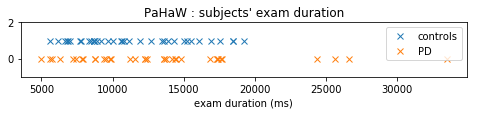

In [17]:
plt.figure(figsize=(8,1))
plt.title("PaHaW : subjects' exam duration")
plt.plot(np.mean(control_time,axis=1),[1 for _ in control_ages],'x',label="controls")
plt.plot(np.mean(patients_time,axis=1),[0 for _ in control_ages],'x',label="PD")
#plt.xlim(10,100)
plt.ylim(-1,2)
plt.xlabel("exam duration (ms)")
plt.legend()

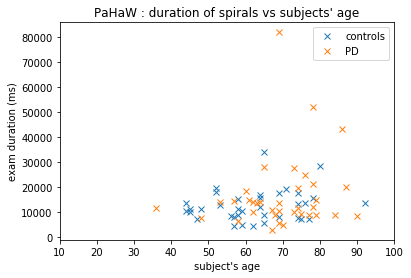

In [398]:
plt.title("PaHaW : duration of spirals vs subjects' age")
plt.xlabel("subject's age")
plt.xlim(10,100)
plt.ylabel("exam duration (ms)")
plt.plot(control_ages,control_time[:,0],'x',label="controls")
plt.plot(patients_ages,patients_time[:,0],'x',label="PD")
plt.legend()

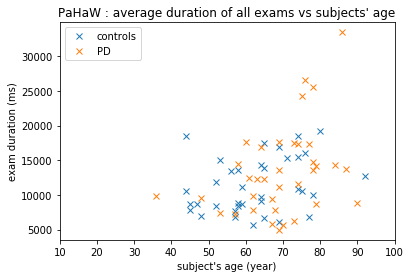

In [395]:
plt.title("PaHaW : average duration of all exams vs subjects' age")
plt.xlabel("subject's age (year)")
plt.xlim(10,100)
plt.ylabel("exam duration (ms)")
plt.plot(control_ages,np.mean(control_time,axis=1),'x',label="controls")
plt.plot(patients_ages,np.mean(patients_time,axis=1),'x',label="PD")
plt.legend()

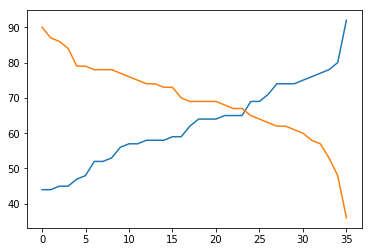

In [9]:

plt.plot(sorted(control_ages))
plt.plot(sorted(patients_ages,reverse=True))

The task sequence is in average **2286** &rarr; task duration is in average 11.4s  

task | duration | duration std | duration per letters
--|--|--|--
spiral | 2758.75 | 2267.76 | NA
l | 1668.01 | 724.14 | 333
le | 1984.16 | 999.61 | 198
les | 2305.01 | 1095.54 | 153
lektorka | 2608.48 | 1333.76  | 163
porovnat | 2315.08 | 1033.69 |144
nepopadnout | 1469.29 | 650.65 | 133
tram | 3086.13 | 1158.81 | 146

## Exploration

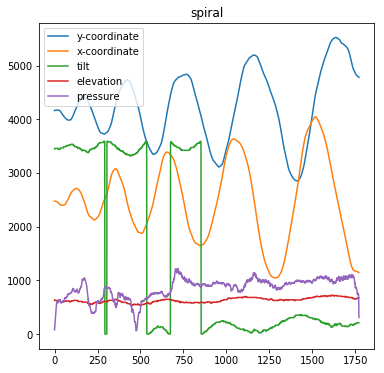

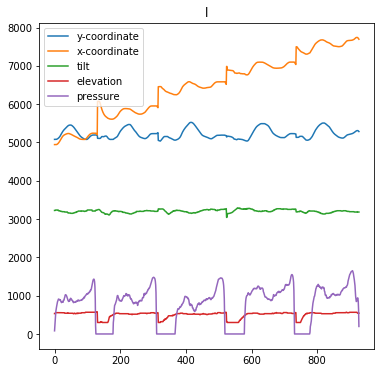

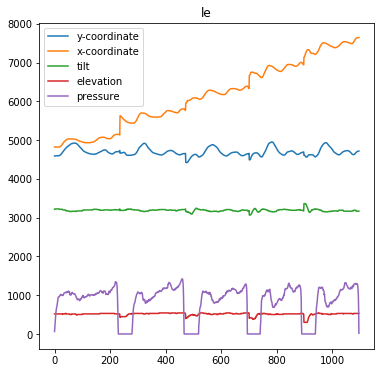

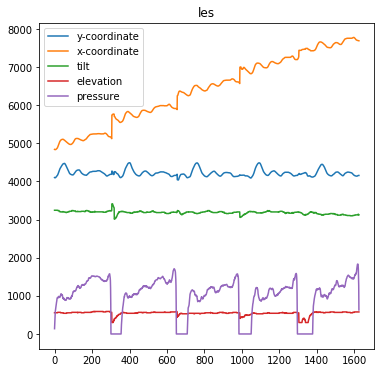

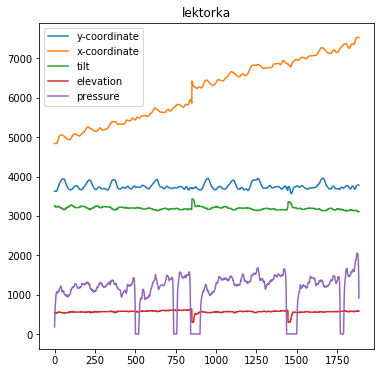

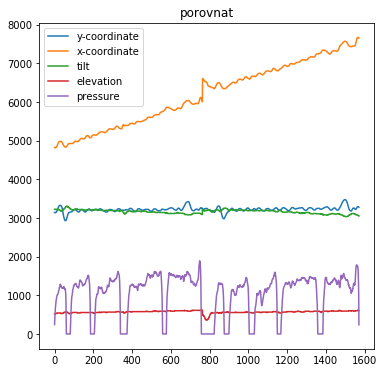

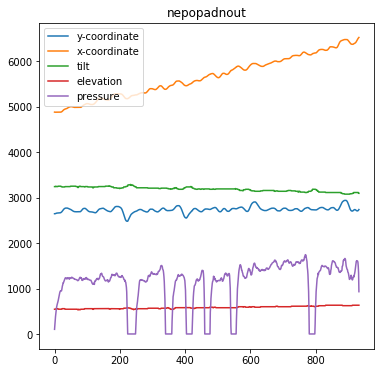

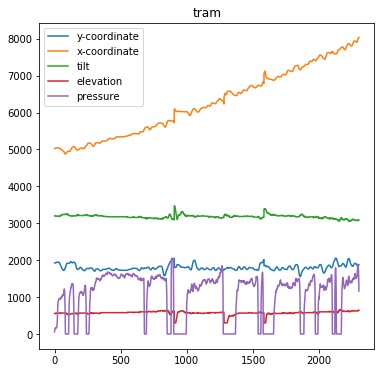

In [8]:
%matplotlib inline
subject_index=0#np.random.randint(0,len(labels))
for j in range(8):
    task=np.asarray(data[subject_index][j])
    plt.figure(figsize=(6,6))
    plt.title(index2task[j])
    for i in [0,1,4,5,6]:
        plt.plot(task[:,i],label=index2measure[i])
        plt.legend()
    

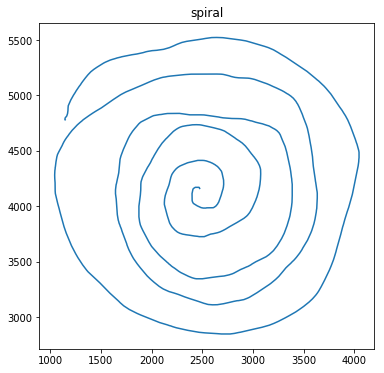

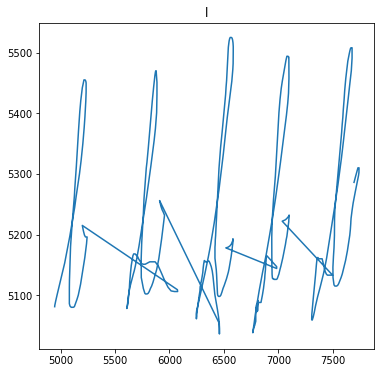

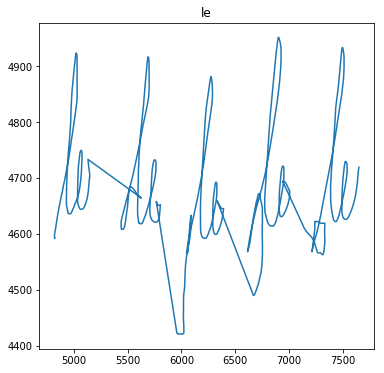

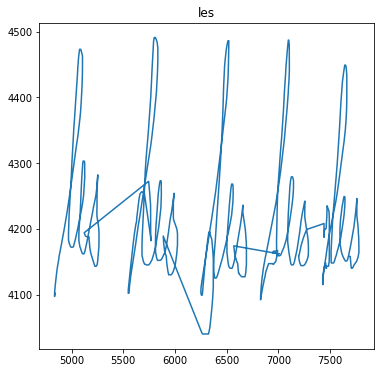

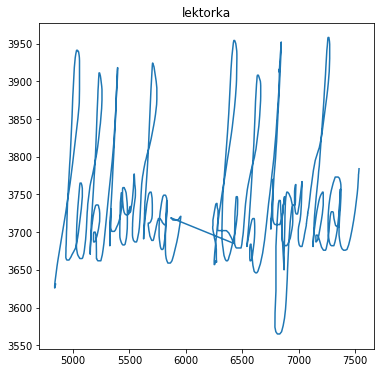

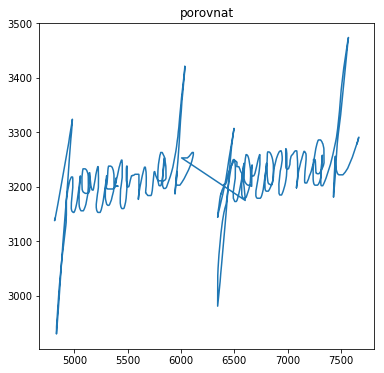

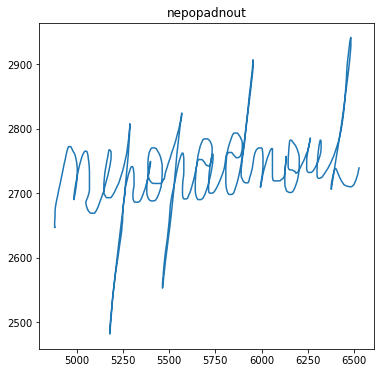

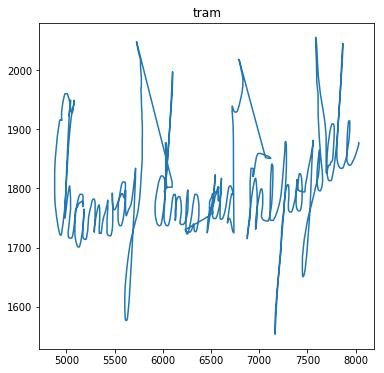

In [10]:
%matplotlib inline
subject_index=0#np.random.randint(0,len(labels))
for j in range(8):
    task=np.asarray(data[subject_index][j])
    plt.figure(figsize=(6,6))
    plt.title(index2task[j])
    plt.plot(task[:,1],task[:,0])

In [17]:
def DetectPause(time):
    """looks through the difference between 2 consecutives points of the timestamp of a task
    to detect if there's pauses during the recording
    
    Returns :
    - True if a Pause was detected
    - False if not"""
    timediff = [time[t+1]-time[t] for t in range(len(time)-1)]
    #print(timediff)
    for t in timediff:
        if t!=7 and t!=8:
            return True
    return False

In [18]:
patients_pause=0
controls_pause=0
for i in range(72):
    for j in range(7):
        if DetectPause(data[i][j][:,2]):
            if targets[i]==1:
                patients_pause+=1
            else:
                controls_pause+=1

In [19]:
patients_pause,controls_pause

(238, 236)

After investigation I found that most of the exams contained (really) small pauses.  
Therefore, the timestamp measure might be useful so the model has a sense of these pauses.  

# Exam finishing in air
On May 16th I corrected this in the `load_data` function so there shouldn't be any problem now.

subject 43 (PD) task tram. 
See below, it starts after timestep (-12).  

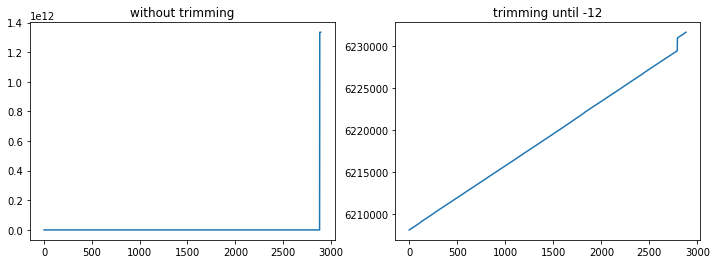

In [281]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.title("without trimming")
plt.plot(np.array(data[43][-1])[:,2])
plt.subplot(122)
plt.title("trimming until -12")
plt.plot(np.array(data[43][-1])[:-12,2])

### Exam starting in air
After excluding subjects who didn't perform the spiral and task and counting from 0 :  
The subjects 56, 9, 39 and 67 and task 0, 1, 4, and 7 respectively started their exam while pen was in air (i.e. not on paper).  
As you can see below it's neglectable for subjects 56 and 67 but leads to quite different plots for subjects 9 and 39.

In [11]:
in_air=[(i,j,targets[i])  for j,_ in enumerate(subject) for i,subject in enumerate(data) if data[i][j][0][3] != 1]
print(in_air)

[(56, 0, 0), (9, 1, 1), (39, 4, 0), (67, 7, 0)]


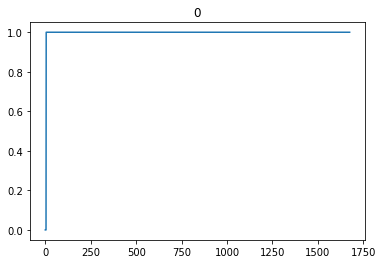

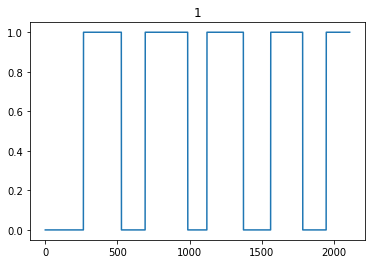

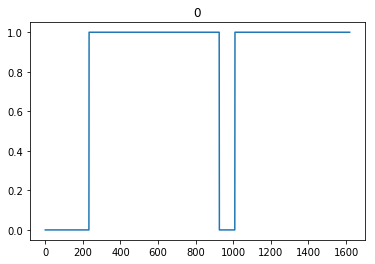

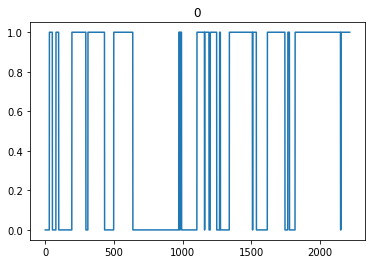

In [12]:
for i,j,p in [(i,j,targets[i])  for j,_ in enumerate(subject) for i,subject in enumerate(data) if data[i][j][0][3] != 1]:
    task=np.asarray(data[i][j])
    plt.figure()
    plt.title(p)
    plt.plot(task[:,3])

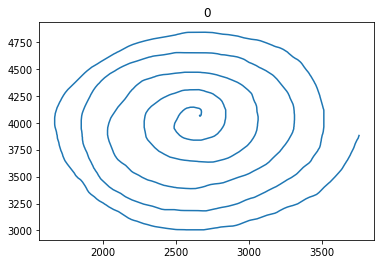

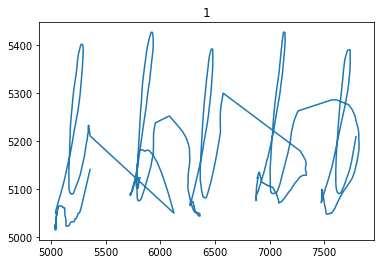

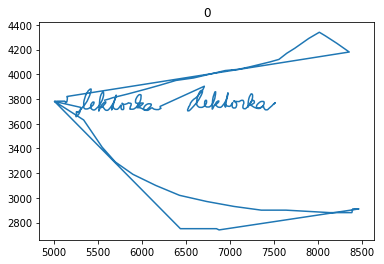

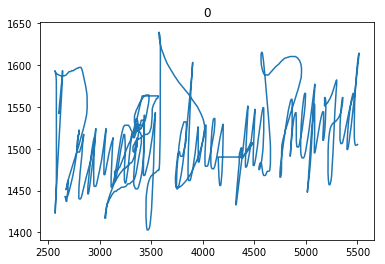

In [13]:
for i,j,p in [(i,j,targets[i])  for j,_ in enumerate(subject) for i,subject in enumerate(data) if data[i][j][0][3] != 1]:
    task=np.asarray(data[i][j])
    plt.figure()
    plt.title(p)
    plt.plot(task[:,1],task[:,0])

## Preprocessing


### Standardize
along axis 0 in order to normalize all the measures independently (i.e. not all time steps independently)  
Cf. Report #4 : it's better to standardize than to normalize !

0


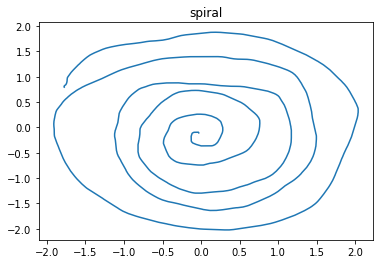

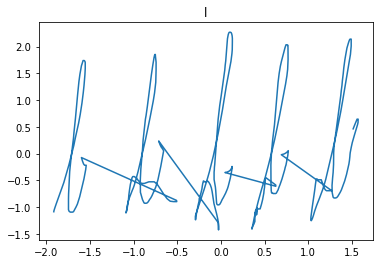

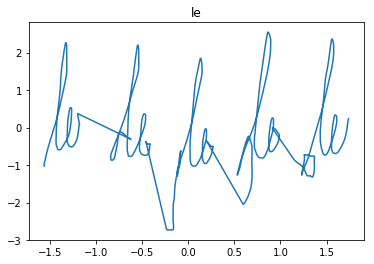

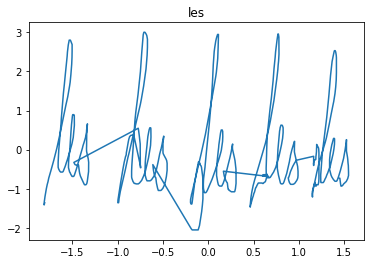

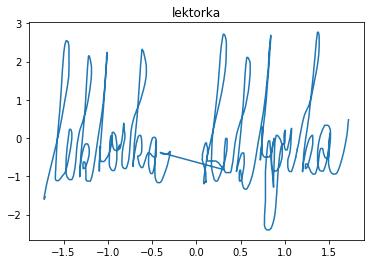

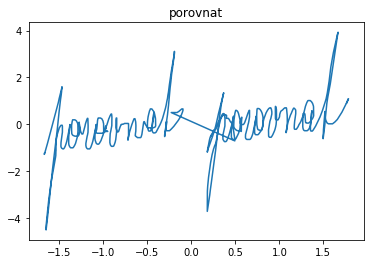

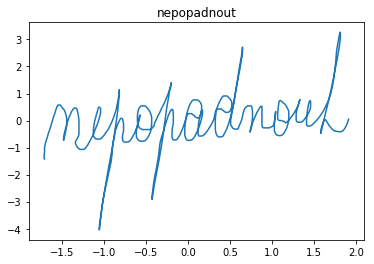

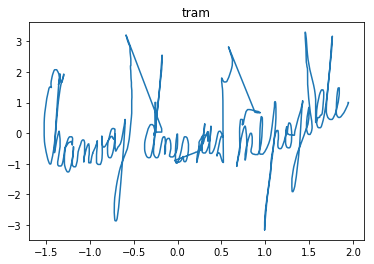

In [15]:
%matplotlib inline
subject_index=0#np.random.randint(0,len(labels))
print(subject_index)
for j in range(8):
    task=scale(np.asarray(data[subject_index][j]),axis=0)
    if task.size!=0:
        plt.figure()
        plt.title(index2task[j])
        plt.plot(task[:,1],task[:,0])
    else:
        print("Subject n° {} didn't perform {} task".format(subject_index,index2task[j]))

### Dowsampling
downsamples using [SciPy's decimate](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.decimate.html).  
After experiment [SciPy's resample](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample.html) is ineffective as the signal is not periodic

In [ ]:
The tasks 0, 1, 4, and 7 from subjects 56, 9, 39 and 67, respectively, started their exam while pen was in air (i.e. not on paper). All these subjects are control except for n° 9.


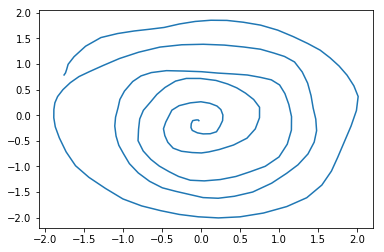

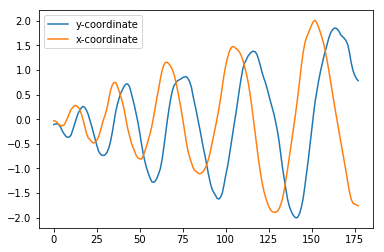

In [16]:
downsampling_factor=10#the sequence will be 10 times shorter !
task=scale(np.asarray(data[0][0]),axis=0)
sparse_spiral=decimate(task,downsampling_factor,axis=0)
%matplotlib inline
plt.figure()
plt.plot(sparse_spiral[:,1],sparse_spiral[:,0])
plt.figure()
for i in [0,1]:
    plt.plot(sparse_spiral[:,i],label=index2measure[i])
    plt.legend()
